In [34]:
import math
import random
import os

import numpy as np

from comet_ml import API
from matplotlib import pyplot as plt
import pandas as pd

COMET_API_KEY="bSyRm6vJpAwfehizXic7Fo0bY"
COMET_REST_API_KEY="S3g50KZWG8zEgk1PLzKUn0eEq"

In [35]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto")

results = {
    'no-transfer': [],
    'human-sc': [],
    'human-sitw': [],
    'human-vctk': [],
    'nohuman-esc50': [],
    'nohuman-audioset': [],    
}

for exp in experiments:
    tags = client.get_experiment_tags(exp)
    
    if len(tags) > 0 and tags[0] in results.keys():
        tag = tags[0]
        metrics = client.get_experiment_metrics(exp)
        params = client.get_experiment_parameters(exp)
        for metric in metrics:
            if metric['name'] == 'test_F1':
                results[tag].append(metric['valueMax'])
                

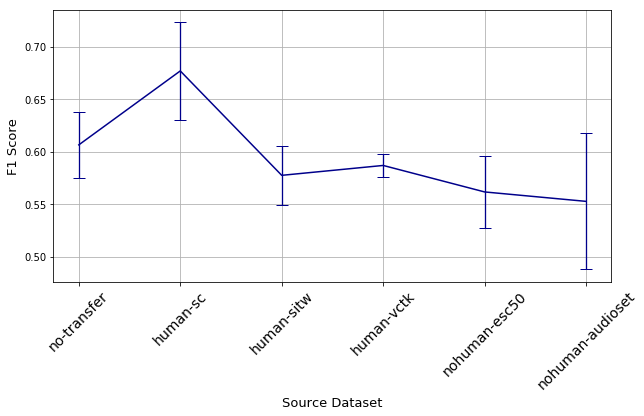

In [36]:
errors = []
xs = []
ys = []
for idx, (k, values) in enumerate(results.items()):
    xs.append(k)
    values = [float(v) for v in values]
    ys.append(np.mean(values))
    errors.append(np.std(values))

fig, ax = plt.subplots(figsize=(10,5))

el = ax.errorbar(xs, ys, yerr=errors, fmt='-', color='darkblue', ecolor='darkblue', elinewidth=1.3, capsize=6)
elines = el.get_children()
#elines[3].set_color('green')
ax.set_xticklabels(results.keys(), rotation=45, fontsize=14)
ax.set_ylabel('F1 Score', fontsize=13)
ax.set_xlabel('Source Dataset', fontsize=13)
plt.grid()
plt.show()




In [37]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)
experiments = client.get("co-jl-transfer/chillanto-noise")

results = {
    'gaussian': {
        'no-transfer': [],
        'human-sc': [],
    },
    'children_playing': {
        'no-transfer': [],
        'human-sc': [],
    }
}


for exp in experiments:
    noise_type = None
    for param in client.get_experiment_parameters(exp):
        if param['name'] == 'noise_type':
            noise_type = param['valueCurrent']

    if noise_type is None:
        continue

    tags = client.get_experiment_tags(exp)
    if len(tags) > 0 and tags[0] in results['gaussian'].keys():
        tag = tags[0]
        experiment = []
        metrics = client.get_experiment_metrics_raw(exp)
        for metric in metrics:
            if metric['metricName'] == 'test_F1':
                experiment.append(float(metric['metricValue']))
        results[noise_type][tag].append(experiment)

In [38]:
results_w_errors = {
    'gaussian': {},
    'children_playing': {}
}

for noise_type in results.keys():
    for source_model in results[noise_type].keys():
        mu = np.mean(results[noise_type][source_model], axis=0)
        std = np.std(results[noise_type][source_model], axis=0)
        results_w_errors[noise_type][source_model] = (mu, std)

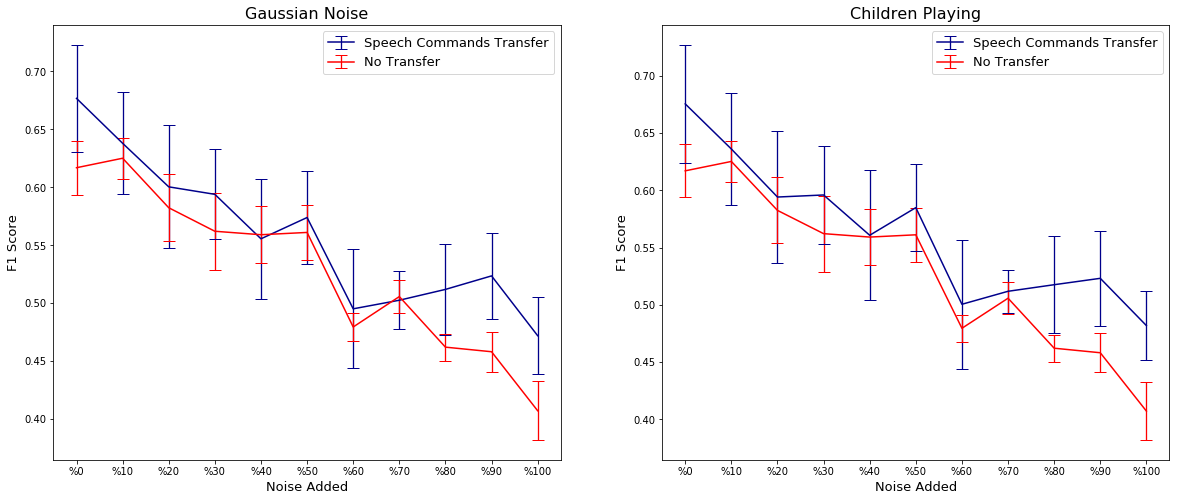

In [39]:
lines = [
    ('human-sc', 'darkblue', 'Speech Commands Transfer'),
    ('no-transfer', 'red', 'No Transfer'),    
]

fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharex=True)
axs[0].set_ylabel("F1 Score", fontsize=13)
axs[1].set_ylabel("F1 Score", fontsize=13)
axs[0].set_xlabel("Noise Added", fontsize=13)
axs[1].set_xlabel("Noise Added", fontsize=13)
plt.xticks(np.arange(11), [f'%{(v) * 10}' for v in range(11)])
for idx, key in enumerate(results.keys()):
    for (line, color, label) in lines: 
        xs = np.arange(11)
        ys = results_w_errors[key][line][0]
        errors = results_w_errors[key][line][1]
        axs[idx].errorbar(xs, ys, yerr=errors, fmt='-', color=color, label=label, ecolor=color, elinewidth=1.3, capsize=6)

        
axs[0].set_title("Gaussian Noise", fontsize=16)
axs[1].set_title("Children Playing", fontsize=16)
axs[0].legend(fontsize=13)
axs[1].legend(fontsize=13)
plt.show()


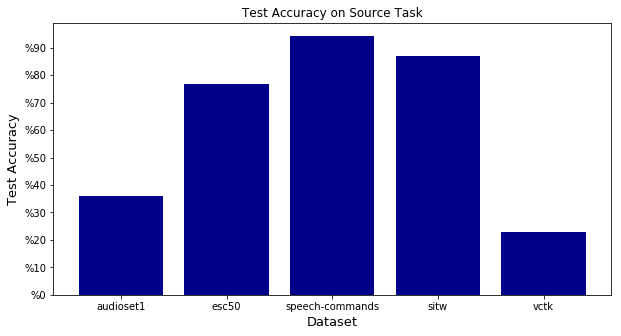

In [32]:
#API.get_experiment_metrics()
client = API(api_key=COMET_API_KEY, rest_api_key=COMET_REST_API_KEY)

projects = ('audioset1-train-and-evaluate',
            'esc50-train-and-evaluate',
            'speech-commands-train-and-evaluate',
            'sitw-train-and-evaluate',
            'vctk-train-and-evaluate')


results = {}

for project in projects:
    best_val = 0.
    experiments = client.get(f"co-jl-transfer/{project}")
    for exp in experiments:
        tags = client.get_experiment_tags(exp)
        if 'candidate' in tags:
            metrics = client.get_experiment_metrics(exp)
            for metric in metrics:
                if metric['name'] == 'test_accuracy':
                    best_val = metric['valueMax']

    results[project.replace('-train-and-evaluate','')] = float(best_val)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(list(results.keys()), list(results.values()), color='darkblue')
plt.yticks(np.arange(10) / 10, [f'%{(v) * 10}' for v in range(10)])

ax.set_title("Test Accuracy on Source Task")
ax.set_xlabel("Dataset", fontsize=13)
ax.set_ylabel("Test Accuracy", fontsize=13)
plt.show()